In [1]:
%matplotlib inline
from IPython.display import YouTubeVideo
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

import video

In [2]:
mpl.rcParams.update({'font.size': 18})

# Reading telemetry off of SpaceX streams

Always displayed, so should be easy enough to parse out every frame. Lets use the Orbcomm one for funsies:

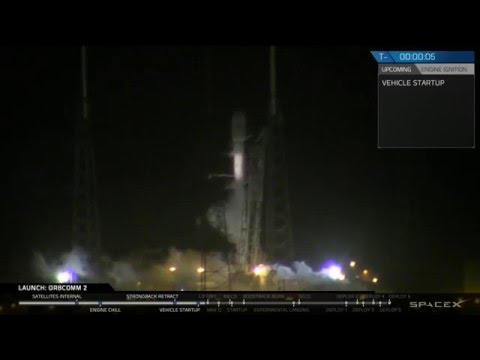

In [3]:
width = 600
YouTubeVideo('O5bTbVbe4e4', width=width, height=width*1080/1920)

YouTubeDL works great. `pip install youtube-dl; youtube-dl https://www.youtube.com/watch?v=O5bTbVbe4e4`

In [4]:
vid = video.Video("ORBCOMM-2 Full Launch Webcast-O5bTbVbe4e4.webm")

In [5]:
# times
f_launch = 41469 # first frame of "t-plus"
f_100km = 46339 # altitude format switches at 100 km

# digit locations
rloc_alt = [(210, 240), (1768, 1845)]
rloc_vel = [(210, 240), (1560, 1670)]
rloc_time = [(32, 62), (1510, 1750)]

def slicify(ranges):
    return tuple(slice(*r) for r in ranges)

loc_alt = slicify(rloc_alt)
loc_vel = slicify(rloc_vel)
loc_time = slicify(rloc_time)

locs = np.array([[ 214, 1566],
                 [ 214, 1586],
                 [ 214, 1606],
                 [ 214, 1626],
                 [ 214, 1646]])

digit_size = 25, 18
slocs = []
for loc in locs:
    x, y = loc
    w, h = digit_size
    slocs.append(slicify([(x, x+w), (y, y+h)]))

In [6]:
examples = [
    {'digit': '0', 'frame': f_launch, 'position': 0},
    {'digit': '1', 'frame': f_launch + 13308, 'position': 0},
    {'digit': '2', 'frame': f_launch + 13308, 'position': 1},
    {'digit': '3', 'frame': f_launch + 3500, 'position': 1},
    {'digit': '4', 'frame': f_launch + 1000, 'position': 4},
    {'digit': '5', 'frame': f_launch + 6000, 'position': 1},
    {'digit': '6', 'frame': f_launch + 3000, 'position': 3},
    {'digit': '7', 'frame': f_launch + 6000, 'position': 4},
    {'digit': '8', 'frame': f_launch + 7000, 'position': 4},
    {'digit': '9', 'frame': f_launch + 3000, 'position': 4},
]
for ex in examples:
    ex['prototype'] = vid.f[ex['frame']].data[slocs[ex['position']]]
    ex['mask'] = ex['prototype'] > 0.5
    ex['prototype'] = ex['prototype'] / ex['prototype'].sum()

In [7]:
def compare_xor(digit):
    digit = digit > 0.5
    return np.argmin([np.bitwise_xor(digit, num['mask']).sum() for num in examples])

In [8]:
def read_iter(vid, f_start, length=None, end=None):
    for frame in vid.frames(f_start, length=length, end=end):
        result = 0
        for n_digit, sloc in enumerate(slocs):
            digit = frame.data[sloc]
            result *= 10
            result += compare_xor(digit)
        yield frame, result

In [ ]:
start = last_n = time.monotonic()
report_period = 500

f_seco = 59000

with open('orbcomm2-vel.txt', 'w') as f:
    f.write('n,t,v\n')
    for n, out in enumerate(read_iter(vid, f_launch, end=f_seco), start=1):
        frame, result = out
        f.write('{},{},{}\n'.format(frame.n, frame.t, result))
        if n % report_period == 0:
            now = time.monotonic()
            elapsed = now - start
            latest = now - last_n
            last_n = now
            print('n = {}, avg: {:0.3f}, last 10: {:0.3f}'.format(n, elapsed / n, latest / report_period))

In [9]:
df = pd.read_csv('orbcomm2-vel.txt')

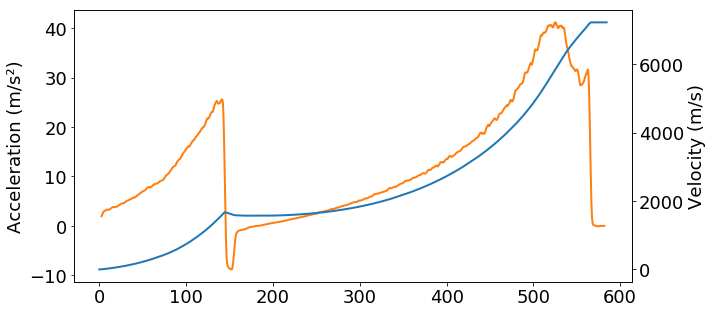

In [10]:
t = df['t']
t = t - t[0]

kph = df['v']
v = kph * 1000 / 3600

a = np.diff(v) * vid.fps

# differentating is noisy
winsize = 150
window = signal.cosine(winsize)
window = window / window.sum()
a = np.convolve(a, window, mode='valid')

f, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()

ax2.plot(t, v, color='C0', lw=2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Velocity (m/s)')

ax.plot(t[winsize//2:-winsize//2], a, color='C1', lw=2)
ax.set_ylabel('Acceleration (m/s²)')

Acceleration peaks at about 2.5 *g* for the first stage, 4 *g* for the second, before it hits about 7000 km/s at SECO (second engine cut-off). Because of the apparent 1 *g* deceleration after MECO (main engine cut-off), the stage must be going mostly 'up', as then the acceleration vector (gravity) would be directly opposite the velocity vector.